In [16]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, RocCurveDisplay

from tqdm import tqdm

In [17]:
data = np.load('processed_ntuples\chunk_data.npy')
np.shape(data)

(529663, 33)

In [18]:
train, val = train_test_split(data, random_state=137) # setting the seed for reproducibility; the default train/test split is 0.75/0.25
print('lenght of training set', len(train), '\nlenght of validation set', len(val), '\nwidth of the sets: # of features + 1 flag (1-LL/0-TX)', len(train[0]))

lenght of training set 397247 
lenght of validation set 132416 
width of the sets: # of features + 1 flag (1-LL/0-TX) 33


In [19]:
# strip the last feature (e.g. the flag) from the sets

# copy in dedicated arrays
flags_train = train[:, -1]
flags_val = val[:, -1]
# delete from the sets
train = train[:, :-1]
val = val[:, :-1]
# width check
print(len(train[0]), len(val[0]))

32 32


In [20]:
# tensorize the data, so that pytorch doesn't whine
train = torch.tensor(train, dtype=torch.float32)
val = torch.tensor(val, dtype=torch.float32)
flags_train = torch.tensor(flags_train, dtype=torch.float32)
flags_val = torch.tensor(flags_val, dtype=torch.float32)

In [21]:
# creation of the model class
# (don't know if the sigmoid is defined in the best way possibile; this one just works)
sigmoid = nn.Sigmoid()
class myModel(nn.Module):
    def __init__(self):
        super(myModel, self).__init__()
        self.dense1 = nn.Linear(32, 64)
        self.BatchNorm1d = nn.BatchNorm1d(64)
        self.relu1 = nn.ReLU()
        self.Dropout = nn.Dropout(0.25)
        self.dense2 = nn.Linear(64, 32)
        self.BatchNorm1d = nn.BatchNorm1d(32)
        self.relu2 = nn.ReLU()
        self.Dropout = nn.Dropout(0.25)
        self.dense3 = nn.Linear(32, 32)
        self.BatchNorm1d = nn.BatchNorm1d(32)
        self.relu3 = nn.ReLU()
        self.Dropout = nn.Dropout(0.25)
        self.dense4 = nn.Linear(32, 1)
    def forward(self, x):
        x = self.dense1(x)
        x = self.relu1(x)
        x = self.dense2(x)
        x = self.relu2(x)
        x = self.dense3(x)
        x = self.relu3(x)
        x = self.dense4(x)
        x = sigmoid(x)
        return x

In [22]:
model = myModel()

loss_function = nn.BCELoss() # CrossEntropyLoss but for just one class
learning_rate = 1.e-3
optimizer = optim.Adam(model.parameters(), lr=learning_rate) # how much the learning rate matter? the default one is 0.001

In [23]:
# training
losses = []
val_losses = []
n_epochs = 30
batch_size = 1000 # size of each batch
batch_start = torch.arange(0, len(train), batch_size)

for epoch in range(n_epochs):

    model.train()
    with tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
            bar.set_description(f"Epoch {epoch}")
            for start in bar:
                # take a batch
                train_batch = train[start:start+batch_size]
                flags_train_batch = flags_train[start:start+batch_size]
                # forward pass
                outputs = model(train_batch)
                loss = loss_function(outputs, flags_train_batch.unsqueeze(0).T)
                # backward pass
                optimizer.zero_grad()
                loss.backward()
                # update weights
                optimizer.step()
                # print progress
                acc = (outputs.round() == flags_train_batch).float().mean()
                bar.set_postfix(
                    loss=float(loss),
                    acc=float(acc)
                )
    losses.append(loss)

    model.eval()
    with torch.no_grad():
        val_outputs = model(val)
        val_loss = loss_function(val_outputs, flags_val.unsqueeze(0).T)
        val_losses.append(val_loss)
        accuracy = float((val_outputs.round().T == flags_val).float().mean())

    print(f'Epoch: {epoch}, Loss: {loss:.3f}, Validation Loss: {val_loss:.3f}')

Epoch: 0, Loss: 0.557, Validation Loss: 0.574
Epoch: 1, Loss: 0.518, Validation Loss: 0.549
Epoch: 2, Loss: 0.476, Validation Loss: 0.528
Epoch: 3, Loss: 0.456, Validation Loss: 0.506
Epoch: 4, Loss: 0.431, Validation Loss: 0.474
Epoch: 5, Loss: 0.408, Validation Loss: 0.439
Epoch: 6, Loss: 0.366, Validation Loss: 0.394
Epoch: 7, Loss: 0.322, Validation Loss: 0.346
Epoch: 8, Loss: 0.285, Validation Loss: 0.310
Epoch: 9, Loss: 0.264, Validation Loss: 0.286
Epoch: 10, Loss: 0.241, Validation Loss: 0.266
Epoch: 11, Loss: 0.220, Validation Loss: 0.251
Epoch: 12, Loss: 0.199, Validation Loss: 0.240
Epoch: 13, Loss: 0.181, Validation Loss: 0.231
Epoch: 14, Loss: 0.172, Validation Loss: 0.222
Epoch: 15, Loss: 0.170, Validation Loss: 0.214
Epoch: 16, Loss: 0.166, Validation Loss: 0.205
Epoch: 17, Loss: 0.161, Validation Loss: 0.199
Epoch: 18, Loss: 0.154, Validation Loss: 0.193
Epoch: 19, Loss: 0.147, Validation Loss: 0.188
Epoch: 20, Loss: 0.137, Validation Loss: 0.184
Epoch: 21, Loss: 0.140,

In [24]:
# transform the tensors to numpy for plotting
losses = np.array([l.detach().numpy() for l in losses])
val_losses = np.array([l.detach().numpy() for l in val_losses])

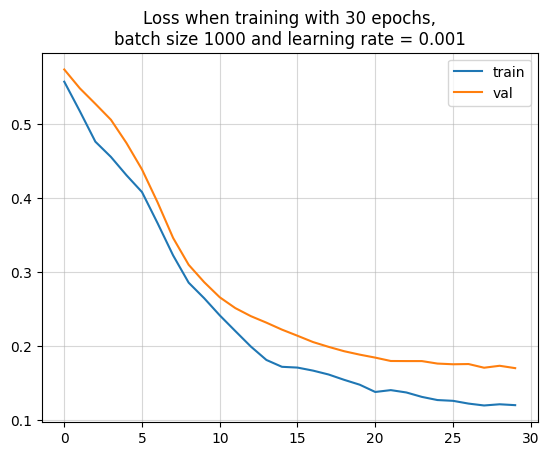

In [25]:
plt.plot(list(range(n_epochs)), losses, label='train')
plt.plot(list(range(n_epochs)), val_losses, label='val')
plt.title(f'Loss when training with {n_epochs} epochs,\nbatch size {batch_size} and learning rate = {learning_rate}')
plt.grid(alpha=0.5)
plt.legend()
plt.savefig(f'loss_red3LayersDropoutBatchNorm_{n_epochs}_{batch_size}_{learning_rate}.png')

In [26]:
# transform the tensors to numpy for plotting
val_outputs = val_outputs.detach().numpy()
flags_val = flags_val.detach().numpy()

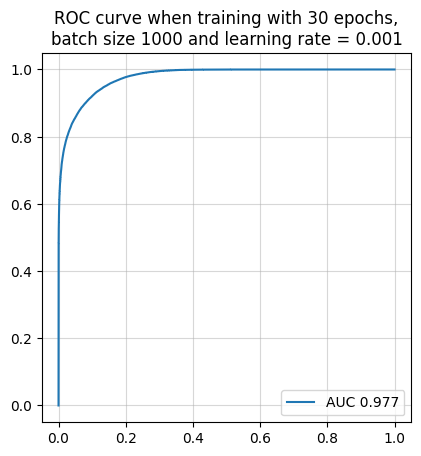

In [27]:
fpr, tpr, thresholds = roc_curve(flags_val, val_outputs)

auc = roc_auc_score(flags_val, val_outputs)

plt.plot(fpr, tpr, label=f'AUC {auc:.3f}')
plt.title(f'ROC curve when training with {n_epochs} epochs,\nbatch size {batch_size} and learning rate = {learning_rate}')
plt.grid(alpha=0.5)
plt.legend()
plt.axis('square')
plt.savefig(f'ROC_red3LayersDropoutBatchNorm_{n_epochs}_{batch_size}_{learning_rate}.png')

In [28]:
sig = val_outputs[flags_val.T.astype(bool)]
bkg = val_outputs[~flags_val.T.astype(bool)]

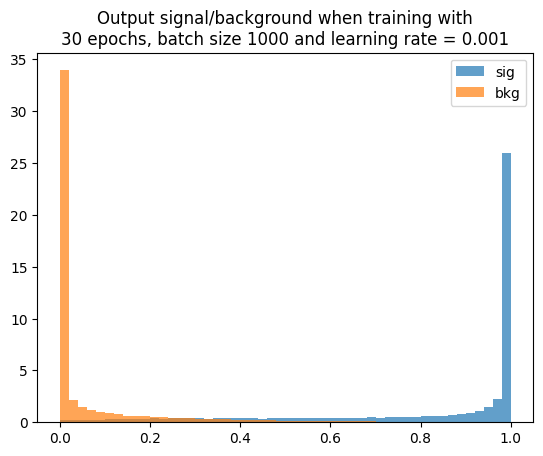

In [29]:
plt.hist(sig, bins=50, density=True, alpha=0.7, label='sig')
plt.hist(bkg, bins=50, density=True, alpha=0.7, label='bkg')
plt.title(f'Output signal/background when training with\n{n_epochs} epochs, batch size {batch_size} and learning rate = {learning_rate}')
plt.legend()
plt.savefig(f'output_red3LayersDropoutBatchNorm_{n_epochs}_{batch_size}_{learning_rate}.png')

In [30]:
#